# Analisis de Base de Datos "Titanic"

Equipo:

Luis Ernesto Ladron de Guevara
Eduardo Angeles Guerrero

In [1]:
''' Importando las librerias '''
# cargando librerias que usare
import pandas as pd # libreria de manejo de funciones para ciencia de datos
import numpy as np # libreria para manejo de arreglos y otras operaciones matematicas
import matplotlib.pyplot as plt # libraria para graficacion de datos
import seaborn as sns # libreria para visualizacion de datos
from sklearn.preprocessing import StandardScaler
import pylab

# paquetes de aprendizaje
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB # especifico para datos numericos y que tengan

#paquete para evaluacion de modelo
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# paquetes para clustering
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

En esta libreta de jupyter haremos nuestro analisis de los datos recopilados en el conjuto de datos sobre el Titanic

Link a la database: https://www.kaggle.com/brendan45774/test-file

Primero, cargamos los datos

In [2]:
titanic = pd.read_csv("titanic.csv") # Leer conjunto de datos

## Estadisticas Iniciales
Estos datos tienen las siguientes estadisticas iniciales

In [3]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Exploración visual de los datos
Ahora procederemos a visualiar las estadística básicas de los datos.

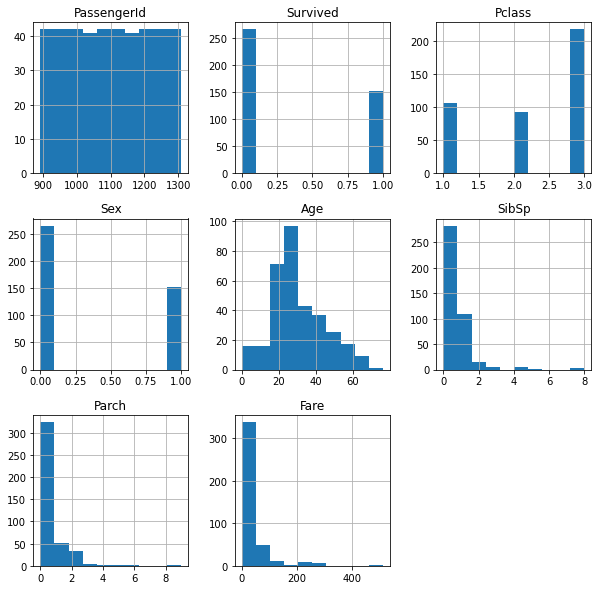

In [4]:
# los valores de sex tendran un rango de 0 a 1
titanic.replace('male', 0, inplace=True)
titanic.replace('female', 1, inplace=True)

titanic.hist(figsize = (10, 10))
plt.show()

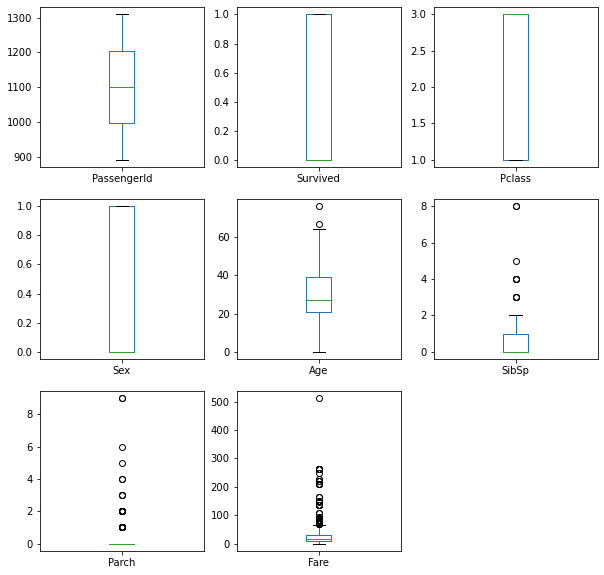

In [5]:
titanic.plot(kind='box', subplots=True, layout=(3,3), sharex=False, figsize = (10,10))
plt.show()

             PassengerId  Survived    Pclass       Sex       Age     SibSp  \
PassengerId     1.000000 -0.023245 -0.026751 -0.023245 -0.034102  0.003818   
Survived       -0.023245  1.000000 -0.108615  1.000000 -0.000013  0.099943   
Pclass         -0.026751 -0.108615  1.000000 -0.108615 -0.492143  0.001087   
Sex            -0.023245  1.000000 -0.108615  1.000000 -0.000013  0.099943   
Age            -0.034102 -0.000013 -0.492143 -0.000013  1.000000 -0.091587   
SibSp           0.003818  0.099943  0.001087  0.099943 -0.091587  1.000000   
Parch           0.043080  0.159120  0.018721  0.159120 -0.061249  0.306895   
Fare            0.008211  0.191514 -0.577147  0.191514  0.337932  0.171539   

                Parch      Fare  
PassengerId  0.043080  0.008211  
Survived     0.159120  0.191514  
Pclass       0.018721 -0.577147  
Sex          0.159120  0.191514  
Age         -0.061249  0.337932  
SibSp        0.306895  0.171539  
Parch        1.000000  0.230046  
Fare         0.230046  1.

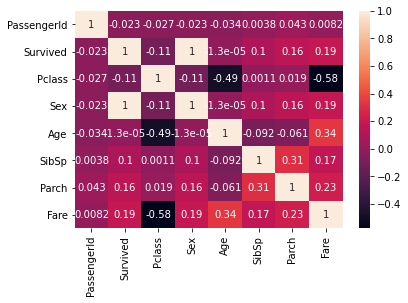

In [6]:
attributes = titanic.columns[0:len(titanic.columns)-1]
correlation = titanic[titanic.columns].corr()
print(correlation)

sns.heatmap(correlation, annot=True)
plt.show()

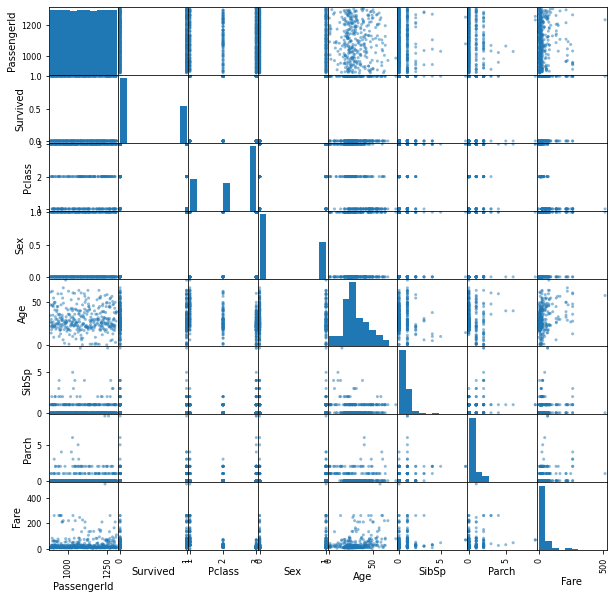

In [7]:
pd.plotting.scatter_matrix(titanic, figsize = (10, 10))
plt.show()

Para poder visualizar los datos mejor, mapearemos las variables que nos interesan a nuestra dataframe, como a continuación

In [8]:
def mappedDF(df):
    surv = {0: 0, 1: 1}
    df['Survived'] = df['Survived'].map(surv)
    
    classes = {1: 'Upper class', 2: 'Middle class', 3: 'Lower class'}
    df['Pclass'] = df['Pclass'].map(classes)
    
    town = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}
    df['Embarked'] = df['Embarked'].map(town)
    
    return(df)

tdf = mappedDF(titanic)

In [9]:
#tdf = tdf.drop(['Cabin','Ticket','Fare'], axis=1)
tdf = tdf.drop(['Ticket', 'Fare', 'Cabin'], axis=1)
tdf

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked
0,892,0,Lower class,"Kelly, Mr. James",0,34.5,0,0,Queenstown
1,893,1,Lower class,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,Southampton
2,894,0,Middle class,"Myles, Mr. Thomas Francis",0,62.0,0,0,Queenstown
3,895,0,Lower class,"Wirz, Mr. Albert",0,27.0,0,0,Southampton
4,896,1,Lower class,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,Southampton
...,...,...,...,...,...,...,...,...,...
413,1305,0,Lower class,"Spector, Mr. Woolf",0,NaN,0,0,Southampton
414,1306,1,Upper class,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,Cherbourg
415,1307,0,Lower class,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,Southampton
416,1308,0,Lower class,"Ware, Mr. Frederick",0,NaN,0,0,Southampton


In [10]:
table = pd.crosstab(tdf['Survived'], tdf['Sex'])

<AxesSubplot:>

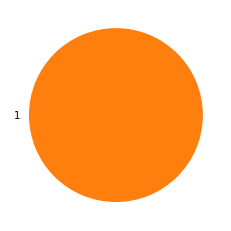

In [11]:
tdf.groupby('Sex').Survived.mean().plot(kind='pie', ylabel='')

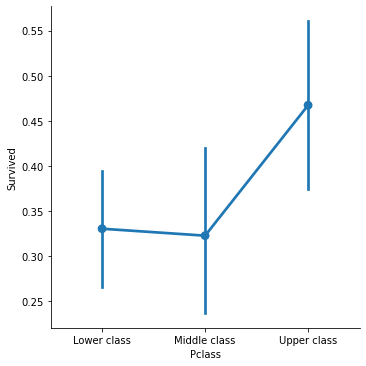

In [12]:
sns.factorplot('Pclass','Survived',data=tdf)

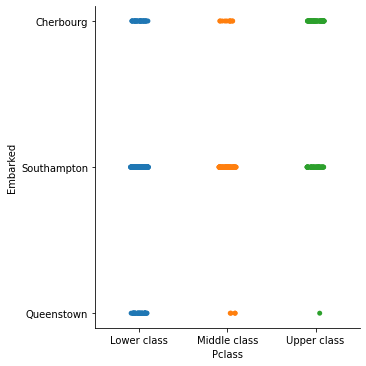

In [13]:
sns.catplot('Pclass','Embarked',data=tdf)

## Preprocesamiento de Datos

La base de datos del titcanic cuenta con algunas columnas cuyos datos son strings, Name, Sex, Ticket, Cabin y Embarked. De estos datos, consideramos que los únicos relevantes, al momento de hacer análisis, son Sex y Embarked. Por ello se borraron las columnas de Name, Ticket y Cabin, y convertimos a numero las variables de Sex y Embarked.

In [14]:
titanic = pd.read_csv("titanic.csv") # Leer conjunto de datos
# los valores de sex tendran un rango de 0 a 1
titanic.replace('male', 0, inplace=True)
titanic.replace('female', 1, inplace=True)
# los valores de embarked tendran un rango de 0 a 2
titanic.replace('S', 0, inplace=True) # Southhampton
titanic.replace('Q', 1, inplace=True) # Queenstown
titanic.replace('C', 2, inplace=True) # Cherbourg
# borrar atributos no relevantes
titanic.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], inplace=True, axis=1)
print(titanic)

     Survived  Pclass  Sex   Age  SibSp  Parch      Fare  Embarked
0           0       3    0  34.5      0      0    7.8292         1
1           1       3    1  47.0      1      0    7.0000         0
2           0       2    0  62.0      0      0    9.6875         1
3           0       3    0  27.0      0      0    8.6625         0
4           1       3    1  22.0      1      1   12.2875         0
..        ...     ...  ...   ...    ...    ...       ...       ...
413         0       3    0   NaN      0      0    8.0500         0
414         1       1    1  39.0      0      0  108.9000         2
415         0       3    0  38.5      0      0    7.2500         0
416         0       3    0   NaN      0      0    8.0500         0
417         0       3    0   NaN      1      1   22.3583         2

[418 rows x 8 columns]


Como existen algunos datos que contienen valores de NaN, debemos eliminarlos para que tengan valores utiles para el procesamiento de datos.

In [15]:
col = titanic.columns # obtengo lista de labels de las columnas
titanic.dropna(subset = col, inplace=True) # eliminar filas con algun valor NaN
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,34.5,0,0,7.8292,1
1,1,3,1,47.0,1,0,7.0000,0
2,0,2,0,62.0,0,0,9.6875,1
3,0,3,0,27.0,0,0,8.6625,0
4,1,3,1,22.0,1,1,12.2875,0
...,...,...,...,...,...,...,...,...
409,1,3,1,3.0,1,1,13.7750,0
411,1,1,1,37.0,1,0,90.0000,1
412,1,3,1,28.0,0,0,7.7750,0
414,1,1,1,39.0,0,0,108.9000,2


Una vez hemos limpiado la base de datos, continuamos separando los atributos en la base de datos (X) de la clase (Y).

In [16]:
# comienzo separando los atributos de la clase
X = titanic.iloc[:,1:]
X # almacena todos los atributos

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,1
1,3,1,47.0,1,0,7.0000,0
2,2,0,62.0,0,0,9.6875,1
3,3,0,27.0,0,0,8.6625,0
4,3,1,22.0,1,1,12.2875,0
...,...,...,...,...,...,...,...
409,3,1,3.0,1,1,13.7750,0
411,1,1,37.0,1,0,90.0000,1
412,3,1,28.0,0,0,7.7750,0
414,1,1,39.0,0,0,108.9000,2


In [17]:
# separando la clase
Y = titanic.iloc[:,0]
Y # almacena la clase

0      0
1      1
2      0
3      0
4      1
      ..
409    1
411    1
412    1
414    1
415    0
Name: Survived, Length: 331, dtype: int64

Terminamos con el preprocesamiento con una estandarizacion de los datos.

In [18]:
# estandarizacion/escalamiento de los datos
rescaledX = StandardScaler().fit_transform(X)
Xnuevo = pd.DataFrame(data = rescaledX, columns=X.columns)

## Entrenamiento de Modelo
Una vez finalizada la limpieza, la separación y la estandarización de los datos, podemos continuar con el entrenamiento del modelo predictivo.

In [19]:
# separacion de mis datos para entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(Xnuevo, Y, random_state=11, test_size=0.1, train_size=0.9)

In [20]:
# entrenamiento del modelo de aprencizaje con validacion cruzada con 10 folds
models = [] # lista de modelos de aprendizaje predictivo
models.append(("Naive Bayes", GaussianNB()))
models.append(("Bernoulli", BernoulliNB()))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model, X_train, Y_train, cv=kfold, scoring="accuracy")
    names.append(name)
    results.append(cv_result)

for i in range(len(names)):
    print("Accuracy of ", names[i], " = ", results[i].mean())

Accuracy of  Naive Bayes  =  1.0
Accuracy of  Bernoulli  =  1.0


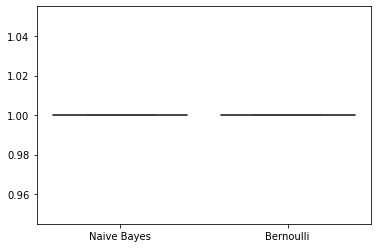

In [21]:
# impresión de los resultados de los modelos
ax = sns.boxplot(data = results)
ax.set_xticklabels(names)
plt.show()

In [22]:
pruebaNaive = GaussianNB() # cargo nuevamente el modelo
pruebaNaive.fit(X_train, Y_train) # genero el modelo con los datos de entrenamiento
naive_prediction = pruebaNaive.predict(X_test) # hacemos la prediccion propiamente dicha

naive_prediction

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], dtype=int64)

In [23]:
print(Y_test)

284    1
345    1
128    0
213    1
302    0
126    0
281    0
295    0
197    1
15     1
370    0
248    1
362    1
373    0
194    0
309    1
277    0
404    0
141    1
63     1
305    1
341    0
293    0
21     0
17     0
71     0
122    1
298    0
385    1
190    0
104    1
388    0
13     0
221    0
Name: Survived, dtype: int64


In [24]:
print("Analisis de precision de la etapa de pruebas")
accuracy_score(Y_test, naive_prediction)

Analisis de precision de la etapa de pruebas


1.0

In [25]:
print(classification_report(Y_test, naive_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        14

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



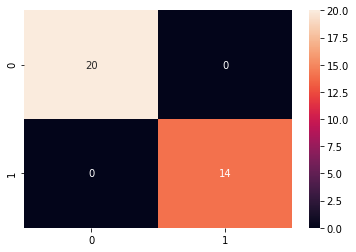

In [26]:
mat_confusion = confusion_matrix(Y_test, naive_prediction)
sns.heatmap(mat_confusion, annot=True)
plt.show()

In [27]:
# Puntaje F1
print("Puntaje de test F1")
f1_score(Y_test, naive_prediction, average='weighted')

Puntaje de test F1


1.0

In [28]:
# Puntaje de recall
print("Puntaje de test recall")
recall_score(Y_test, naive_prediction, average='weighted')

Puntaje de test recall


1.0

## Analisis de Datos por Clustering

In [29]:
k = 3
kmeans = KMeans(n_clusters = k, init='random') # instanciacion del modelo k-means
kmeans.fit(X) # realizo el clustering sobre los datos
centros = kmeans.cluster_centers_
centros

array([[  1.12068966,   0.5       ,  38.06034483,   0.74137931,
          0.46551724,  84.02780517,   1.0862069 ],
       [  1.        ,   0.66666667,  43.80555556,   0.77777778,
          1.        , 252.66250556,   1.33333333],
       [  2.45490196,   0.3372549 ,  27.42745098,   0.40392157,
          0.34117647,  16.24914941,   0.38823529]])

In [30]:
distancias = KMeans.fit_transform(kmeans,X) # distancia
distancias

array([[236.24841632,  73.41979326,  11.04450907],
       [236.9186533 ,  74.73674882,  21.6792583 ],
       [234.90971716,  75.43086812,  35.20356339],
       [235.83336588,  73.32782933,   7.65383022],
       [232.62892986,  70.69566011,   6.84312339],
       [236.55489826,  75.81073037,  15.18144487],
       [236.66685594,  73.96198541,   9.07258008],
       [215.62362946,  53.49847824,  12.87954069],
       [238.06630102,  76.56944692,  13.18521982],
       [220.9289172 ,  59.49129152,  10.34219673],
       [217.9019209 ,  55.7581124 ,  21.03994833],
       [162.95377353,  14.9692105 ,  66.18986113],
       [218.73819312,  60.61988675,  36.89753982],
       [182.74330079,  21.99698184,  49.03667132],
       [217.07105383,  55.20881411,  12.12690606],
       [231.7054671 ,  68.86351958,   8.57445926],
       [237.76501339,  75.85054151,  11.22655829],
       [236.56726421,  74.05349288,   8.41623302],
       [236.67425206,  74.29490708,  19.84548951],
       [184.82959109,  27.70449

In [31]:
nombres_clusters = kmeans.labels_
nombres_clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1,
       0, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2,
       2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 2,

In [32]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,1
1,3,1,47.0,1,0,7.0000,0
2,2,0,62.0,0,0,9.6875,1
3,3,0,27.0,0,0,8.6625,0
4,3,1,22.0,1,1,12.2875,0
...,...,...,...,...,...,...,...
409,3,1,3.0,1,1,13.7750,0
411,1,1,37.0,1,0,90.0000,1
412,3,1,28.0,0,0,7.7750,0
414,1,1,39.0,0,0,108.9000,2


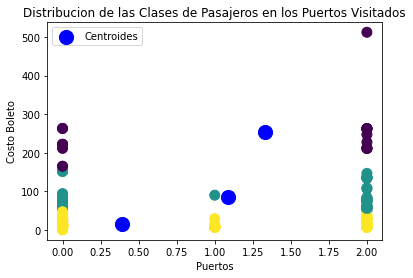

In [33]:
# visualizar los grupos
plt.scatter(X.iloc[:,6],X.iloc[:,5], s=100, c=nombres_clusters)
plt.scatter(centros[:,6], centros[:,5], s=200, c='blue', label = 'Centroides')
plt.title("Distribucion de las Clases de Pasajeros en los Puertos Visitados")
plt.xlabel("Puertos")
plt.ylabel("Costo Boleto")
plt.legend()

plt.show()

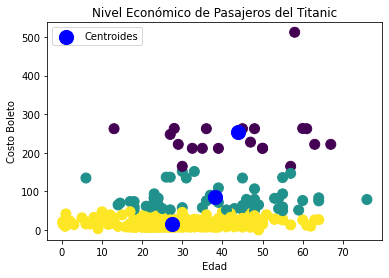

In [34]:
# visualizar los grupos
plt.scatter(X.iloc[:,2],X.iloc[:,5], s=100, c=nombres_clusters)
plt.scatter(centros[:,2], centros[:,5], s=200, c='blue', label = 'Centroides')
plt.title("Nivel Económico de Pasajeros del Titanic")
plt.xlabel("Edad")
plt.ylabel("Costo Boleto")
plt.legend()

plt.show()